In [48]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from copy import deepcopy

discov_val_feats_path = '/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_features_final.csv'
discov_df = pd.read_csv(discov_val_feats_path)
feats_list = pd.read_csv('noncorrolated_feature_list_2.csv', header=None)[0].to_list()
feats_list = [feat for feat in feats_list if feat not in ["mit_clusterCoff_max", "mit_hotspot_score"]]
feats_list = [
    # "mit_clusterCoff_mean",
    "mit_nodeDegrees_mean",
    "mit_hotspot_count",
    # "mit_cenDegree_std",
    # "mit_cenCloseness_perc10",
    # "mit_cenHarmonic_mean",
    # "mit_cenHarmonic_std",
]

df = discov_df[['type']+feats_list]
invalid_cancers = ['UVM'] #  ['MESO', 'UVM', 'TGCT', 'THYM', 'THCA', 'LAML', 'DLBC', 'UCS', 'SARC', 'CHOL', 'PRAD', 'ACC']  # with kept PCPG
df = df[~df['type'].isin(invalid_cancers)]
df['type'] = df['type'].replace(['COAD', 'READ'], 'COADREAD')
df['type'] = df['type'].replace(['GBM', 'LGG'], 'GBMLGG')

# Replace positive infinite values with the maximum finite value in the DataFrame
df = df.replace(np.inf, np.nan)
df = df.dropna()

df[feats_list] = df[feats_list].astype(float)
df_ref = deepcopy(df)



<Figure size 640x480 with 0 Axes>

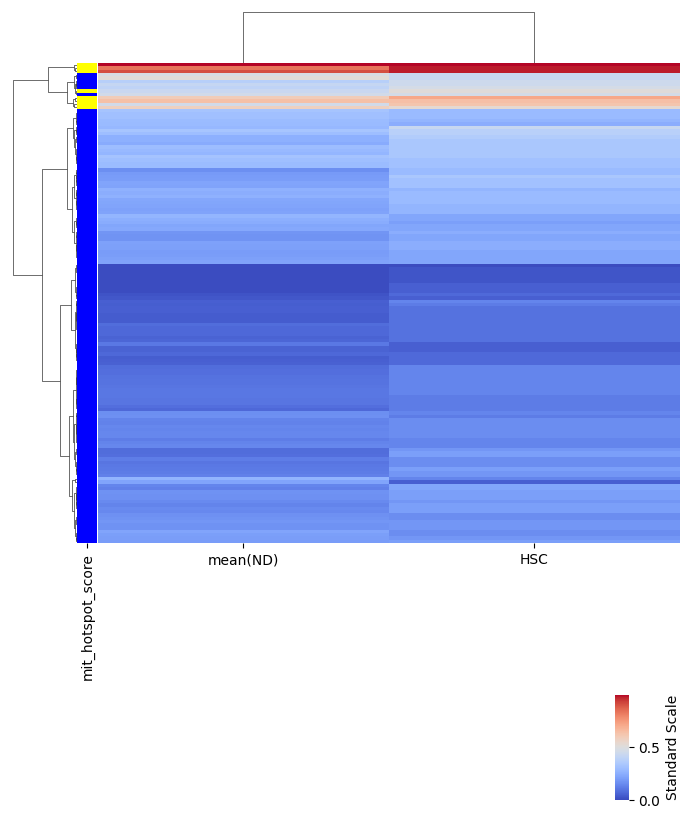

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from utils import get_colors_dict, featre_to_tick


df = df_ref[df_ref['type']=='PCPG']
cancer_types = df['type'].unique()

col_colors = discov_df["mit_hotspot_score"].iloc[df.index.to_list()].map({0:"black", 1:"blue", 2:"yellow", 3:"red"})
# lut = get_colors_dict()
# col_colors = df['type'].map(lut)
# col_colors.index = df.index.tolist()

df = df.drop('type', axis=1)
df.columns = [featre_to_tick(col) if col != 'bcr_patient_barcode' else col for col in df.columns]

# # removing the outliers
q_low = df.quantile(0.01)
q_hi  = df.quantile(0.99)
# df = df[(df > q_low) & (df < q_hi)]


# Replace outliers with the respective quantile values
# for column in df.columns:
#     df[column] = df[column].mask(df[column] < q_low[column], q_low[column])
#     df[column] = df[column].mask(df[column] > q_hi[column], q_hi[column])

# df=(df-df.mean())/df.std()
df=(df-df.min())/(df.max()-df.min()+0.0000001)
# df=(df-df.quantile(0.01))/(df.quantile(0.99)-df.quantile(0.01))
# df = df.dropna()

# plt.figure(),
# g = sns.clustermap(df,cmap='seismic',row_cluster=True,method='ward',col_cluster=False,row_colors=col_colors, standard_scale=0, cbar_kws={"shrink": 0.5})
# legend_patches = [mpatches.Patch(color=lut[i], label=i) for i in cancer_types]
# # plt.legend(handles=legend_patches, bbox_to_anchor=(10, -5), loc='center', ncol=len(cancer_types)//4)
# plt.title('Row Clustering')

# plt.figure(),
# g = sns.clustermap(df,cmap='seismic',row_cluster=False,method='ward',col_cluster=True,row_colors=col_colors, standard_scale=0, cbar_kws={"shrink": 0.5})
# legend_patches = [mpatches.Patch(color=lut[i], label=i) for i in cancer_types]
# # plt.legend(handles=legend_patches, bbox_to_anchor=(10, -5), loc='center', ncol=len(cancer_types)//4)
# plt.title('Column Clustering')

plt.figure(),
g = sns.clustermap(df,cmap='coolwarm',row_cluster=True,method='ward',col_cluster=True,
                   row_colors=col_colors,
                   standard_scale=None, z_score=None,
                   figsize=(7, 7), yticklabels=False, cbar_pos=(0.885, -0.15, 0.02, 0.15), cbar_kws={"label": "Standard Scale"}, dendrogram_ratio=(0.1,0.1)
                   )
# legend_patches = [mpatches.Patch(color=lut[i], label=i) for i in cancer_types]
# plt.legend(handles=legend_patches, bbox_to_anchor=(-20, 0.5), loc='center', ncol=len(cancer_types)//4, title="Type")

# plt.savefig("explain_features/feature_biclustering.png", bbox_inches = 'tight', pad_inches = 0, dpi=600)
# plt.savefig("explain_features/feature_biclustering.pdf", bbox_inches = 'tight', pad_inches = 0, dpi=600)

In [111]:
# calculate and save dendogram clusters of patients
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

# Load data
discov_val_feats_path = '/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_features_clinical_merged.csv'
discov_df = pd.read_csv(discov_val_feats_path)
feats_list = pd.read_csv('noncorrolated_feature_list_2.csv', header=None)[0].to_list()
feats_list = [feat for feat in feats_list if feat not in ["mit_clusterCoff_max", "mit_hotspot_score"]]

# Filter data
df = discov_df[['type'] + feats_list]
invalid_cancers = ['UVM']  # with kept PCPG
df = df[~df['type'].isin(invalid_cancers)]

# Replace positive infinite values with the maximum finite value in the DataFrame
df = df.replace(np.inf, np.nan)
df = df.dropna()

df = df[feats_list].astype(float)

# Normalize data
df = (df - df.min()) / (df.max() - df.min())

# Compute the linkage matrix for rows
row_linkage = linkage(pdist(df), method='ward')


# Choose the number of clusters
for max_clusters in [2,3,4]:
    # Get the cluster labels for rows using max number of clusters
    row_clusters_by_max_clusters = fcluster(row_linkage, max_clusters, criterion='maxclust')

    # Add the cluster labels to the original dataframe
    filtered_indices = df.index
    discov_df[f'cluster_{max_clusters}'] = np.nan
    discov_df.loc[filtered_indices, f'cluster_{max_clusters}'] = row_clusters_by_max_clusters.tolist()

discov_save_path = '/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_features_clinical_merged_clustered.csv'
discov_df.to_csv(discov_save_path, index=None)

DSS
Log-Rank test p-value between Hot and Cold: 0.0000
OS
Log-Rank test p-value between Hot and Cold: 0.0000
PFI
Log-Rank test p-value between Hot and Cold: 0.0000
DFI
Log-Rank test p-value between Hot and Cold: 0.0000


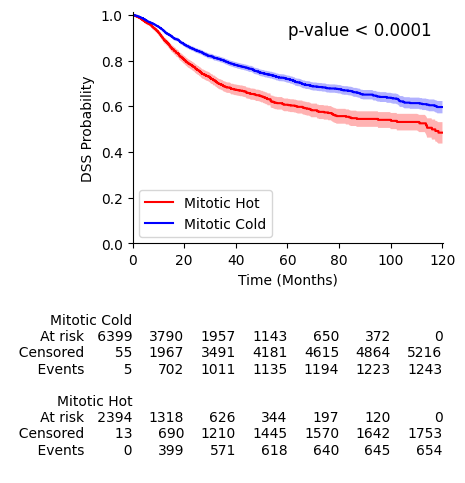

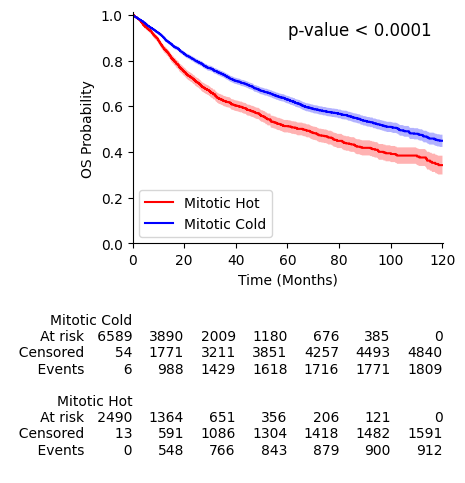

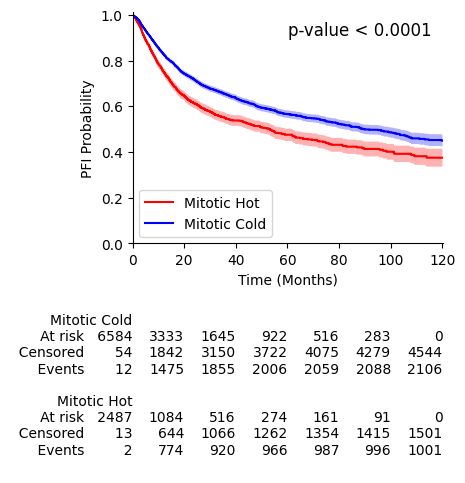

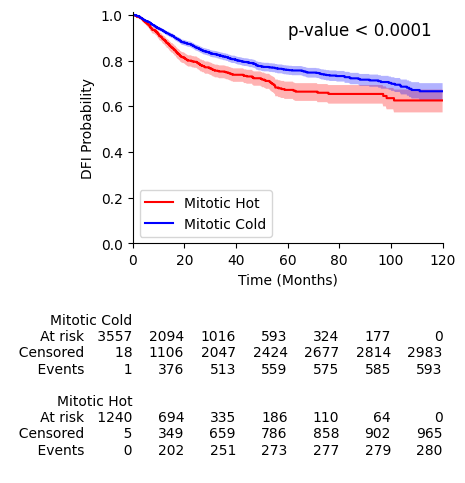

In [1]:
# survival analysis for clustered patients
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from itertools import combinations
import matplotlib.collections as mpl_collections
import os

time_thresh = 120
save_root = f"results_final/survival/pancancer_HotCold_censor{time_thresh}_NEW/"
os.makedirs(save_root, exist_ok=True)

# Load the data
discov_val_feats_path = '/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_features_final_ClusterByCancerNew_withAtypical.csv'
discov_df = pd.read_csv(discov_val_feats_path)

invalid_cancers = ["UVM"] # ['MESO', 'UVM', 'TGCT', 'THYM', 'THCA', 'LAML', 'DLBC', 'UCS', 'SARC', 'CHOL', 'PRAD', 'ACC']  # with kept PCPG
discov_df = discov_df[~discov_df['type'].isin(invalid_cancers)]

# Uncomment to filter based on cancer type
# discov_df = discov_df[discov_df["type"]=="OV"]

for even_type in ["DSS", "OS", "PFI", "DFI"]:
    print(even_type)
    time = f"{even_type}.time"
    event = even_type
    cluster = "temperature"
    df = discov_df[[time, event, cluster]]
    df = df.rename(columns={time: 'time', event: 'event', cluster: 'category'})

    df = df.replace(np.inf, np.nan)
    df = df.dropna()

    # Convert days to months
    df["time"] = df["time"] / 30.4

    # Censor at 10 years (120 months)
    if time_thresh is not None:
        df.loc[df["time"] > time_thresh, "event"] = 0
        df.loc[df["time"] > time_thresh, "time"] = time_thresh

    # Initialize the KaplanMeierFitter
    kmf = KaplanMeierFitter()

    # Plotting KM curves for different categories
    plt.figure(figsize=(4, 3))

    # Define the colors and labels for the categories
    category_colors = {"Cold": 'blue', "Hot": 'red'}
    category_labels = {"Cold": 'Mitotic Cold', "Hot": 'Mitotic Hot'}

    # Get the unique categories
    categories = df['category'].unique()

    for category in categories:
        # Filter the data for the current category
        category_data = df[df['category'] == category]
        kmf.fit(durations=category_data['time'], event_observed=category_data['event'], label=category_labels[category])
        kmf.plot(ci_show=False, color=category_colors[category])
        # Get confidence intervals
        ci = kmf.confidence_interval_
        # Plot fill_between for confidence interval
        plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color=category_colors[category], alpha=0.3, edgecolor=None)

    plt.ylim([0, 1.01])
    plt.xlim([0, df["time"].max(axis=None)+.01])
    # plt.title('Kaplan-Meier Survival Curves for all Cohorts')
    plt.xlabel('Time (Months)')
    plt.ylabel(f'{event} Probability')
    plt.legend(loc = 'lower left')

    # Remove the top and right margins
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Perform Log-Rank test to compare KM curves between all pairs of categories
    results = []
    for (cat1, cat2) in combinations(categories, 2):
        data1 = df[df['category'] == cat1]
        data2 = df[df['category'] == cat2]
        result = logrank_test(data1['time'], data2['time'], event_observed_A=data1['event'], event_observed_B=data2['event'])
        results.append((cat1, cat2, result.p_value))

    # Display p-values for Log-Rank tests
    for cat1, cat2, p_value in results:
        print(f'Log-Rank test p-value between {cat1} and {cat2}: {p_value:.4f}')

    # Add p-value to the plot
    p_value = results[0][2]  # Since there are only two categories, take the first result's p-value
    pv_test = f'p-value: {p_value:.4f}' if p_value>0.0001 else 'p-value < 0.0001'
    plt.text(0.5, 0.90, pv_test, transform=ax.transAxes, fontsize=12)

    plt.savefig(save_root+f"allSurv_{even_type}_censor{time_thresh}.png", bbox_inches = 'tight', pad_inches = 0, dpi=600)
    plt.savefig(save_root+f"allSurv_{even_type}_censor{time_thresh}.pdf", bbox_inches = 'tight', pad_inches = 0, dpi=600)

    # Add at risk counts
    kmf1 = KaplanMeierFitter()
    kmf2 = KaplanMeierFitter()

    kmf1.fit(df[df['category'] == "Cold"]['time'], df[df['category'] == "Cold"]['event'], label='Mitotic Cold')
    kmf2.fit(df[df['category'] == "Hot"]['time'], df[df['category'] == "Hot"]['event'], label='Mitotic Hot')

    from lifelines.plotting import add_at_risk_counts
    add_at_risk_counts(kmf1, kmf2, ax=ax)

    plt.savefig(save_root+f"allSurv_{even_type}_censor{time_thresh}_withCount.png", bbox_inches = 'tight', pad_inches = 0, dpi=600)
    plt.savefig(save_root+f"allSurv_{even_type}_censor{time_thresh}_withCount.png.pdf", bbox_inches = 'tight', pad_inches = 0, dpi=600)


<Figure size 640x480 with 0 Axes>

In [94]:
# calculate and save dendogram clusters of patients
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

# Compute the linkage matrix for rows
row_linkage = linkage(pdist(df), method='ward')


# Choose the number of clusters
for max_clusters in [2]:
    # Get the cluster labels for rows using max number of clusters
    row_clusters_by_max_clusters = fcluster(row_linkage, max_clusters, criterion='maxclust')

    # Add the cluster labels to the original dataframe
    filtered_indices = df.index
    discov_df[f'cluster_{max_clusters}'] = np.nan
    discov_df.loc[filtered_indices, f'cluster_{max_clusters}'] = row_clusters_by_max_clusters.tolist()

# discov_save_path = '/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_features_clinical_merged_clustered.csv'
# discov_df.to_csv(discov_save_path, index=None)

In [27]:
# case clustering into mitotic-hot and mitotic-cold in each cnacer type separately. 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from itertools import combinations
import matplotlib.collections as mpl_collections
import os

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

cancer_types = ['BRCA', 'KIRC', 'UCEC', 'LGG', 'LUSC', 'LUAD', 'HNSC', 'COADREAD', 'SKCM',
       'GBM', 'BLCA', 'STAD', 'LIHC', 'KIRP', 'CESC', 'PAAD', 'ESCA',
       'PCPG', 'KICH', 'OV']

discov_val_feats_path = '/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_features_final.csv'
discov_df = pd.read_csv(discov_val_feats_path)
discov_df['type'] = discov_df['type'].replace(['COAD', 'READ'], 'COADREAD')
discov_df['type'] = discov_df['type'].replace(['GBM', 'LGG'], 'GBMLGG')
discov_df[f'cluster'] = np.nan
discov_df[f'temperature'] = np.nan
cancer_types = discov_df["type"].unique()

feats_list = [
    "mit_hotspot_count",
    "mit_clusterCoff_mean",
    "mit_nodeDegrees_mean",
]

for cancer_type in cancer_types:
    # print(cancer_type)
    df = discov_df[['type']+feats_list]
    df = df[df["type"]==cancer_type]

    # Replace positive infinite values with the maximum finite value in the DataFrame
    df = df.replace(np.inf, np.nan)
    df = df.dropna()

    df[feats_list] = df[feats_list].astype(float)

    # Normalize data
    df[feats_list] = (df[feats_list] - df[feats_list].min()) / (df[feats_list].max() - df[feats_list].min() + 1e-300)

    # Compute the linkage matrix for rows
    row_linkage = linkage(pdist(df[feats_list]), method='ward')

    row_clusters_by_max_clusters = fcluster(row_linkage, 2, criterion='maxclust')

    # Add the cluster labels to the original dataframe
    filtered_indices = df.index
    discov_df.loc[filtered_indices, 'cluster'] = row_clusters_by_max_clusters.tolist()

    # Ensure clusters are integers
    discov_df.loc[filtered_indices, 'cluster'] = discov_df.loc[filtered_indices, 'cluster'].astype(int)

    # Determine which cluster is hot and which is cold based on 'mit_clusterCoff_mean'
    cluster_means = discov_df.loc[filtered_indices].groupby('cluster')['mit_hotspot_count'].mean()

    # Assign hot and cold labels
    hot_cluster = cluster_means.idxmax()
    cold_cluster = cluster_means.idxmin()

    print(f"{cancer_type} -- Hot: {hot_cluster}, Cold: {cold_cluster}")

    discov_df.loc[filtered_indices, 'temperature'] = discov_df.loc[filtered_indices, 'cluster'].apply(lambda x: 'Hot' if x == hot_cluster else 'Cold')

# discov_df = discov_df.drop(columns=['cluster'])
discov_df.to_csv('/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_features_final_ClusterByCancer.csv', index=None)


SARC -- Hot: 2.0, Cold: 1.0
LIHC -- Hot: 1.0, Cold: 2.0
THYM -- Hot: 2.0, Cold: 1.0
ACC -- Hot: 2.0, Cold: 1.0
BRCA -- Hot: 2.0, Cold: 1.0
KICH -- Hot: 2.0, Cold: 1.0
STAD -- Hot: 2.0, Cold: 1.0
BLCA -- Hot: 1.0, Cold: 2.0
THCA -- Hot: 1.0, Cold: 2.0
GBMLGG -- Hot: 2.0, Cold: 1.0
UCEC -- Hot: 1.0, Cold: 2.0
LUAD -- Hot: 2.0, Cold: 1.0
KIRC -- Hot: 2.0, Cold: 1.0
KIRP -- Hot: 2.0, Cold: 1.0
PAAD -- Hot: 1.0, Cold: 2.0
CESC -- Hot: 2.0, Cold: 1.0
PCPG -- Hot: 1.0, Cold: 2.0
MESO -- Hot: 2.0, Cold: 1.0
SKCM -- Hot: 2.0, Cold: 1.0
PRAD -- Hot: 2.0, Cold: 1.0
COADREAD -- Hot: 2.0, Cold: 1.0
ESCA -- Hot: 1.0, Cold: 2.0
LUSC -- Hot: 1.0, Cold: 2.0
HNSC -- Hot: 1.0, Cold: 2.0
OV -- Hot: 1.0, Cold: 2.0
TGCT -- Hot: 1.0, Cold: 2.0
CHOL -- Hot: 2.0, Cold: 1.0
UVM -- Hot: 2.0, Cold: 1.0
DLBC -- Hot: 1.0, Cold: 2.0
UCS -- Hot: 1.0, Cold: 2.0


['ACC']
Hot 17
Cold 39
Log-Rank test p-value between Hot and Cold: 0.5224
['BLCA']
Hot 104
Cold 281
Log-Rank test p-value between Hot and Cold: 0.8465
['BRCA']
Hot 277
Cold 776
Log-Rank test p-value between Hot and Cold: 0.0045
['CESC']
Hot 83
Cold 186
Log-Rank test p-value between Hot and Cold: 0.6588
['CHOL']
Hot 9
Cold 27
Log-Rank test p-value between Hot and Cold: 0.7779
['COADREAD']
Hot 299
Cold 289
Log-Rank test p-value between Hot and Cold: 0.4553
['DLBC']
Hot 9
Cold 25
Log-Rank test p-value between Hot and Cold: 0.3379
['ESCA']
Hot 42
Cold 112
Log-Rank test p-value between Hot and Cold: 0.0181
['GBMLGG']
Hot 369
Cold 503
Log-Rank test p-value between Hot and Cold: 0.0000
['HNSC']
Hot 144
Cold 305
Log-Rank test p-value between Hot and Cold: 0.6050
['KICH']
Hot 25
Cold 83
Log-Rank test p-value between Hot and Cold: 0.0119
['KIRC']
Hot 124
Cold 386
Log-Rank test p-value between Hot and Cold: 0.0000
['KIRP']
Hot 74
Cold 197
Log-Rank test p-value between Hot and Cold: 0.0290
['LIHC'

/tmp/ipykernel_1331005/898583949.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(4, 3))


Log-Rank test p-value between Hot and Cold: 0.7465
['STAD']
Hot 115
Cold 256
Log-Rank test p-value between Hot and Cold: 0.5186
['TGCT']
Hot 41
Cold 80
Log-Rank test p-value between Hot and Cold: 0.3318
['THCA']
Hot 104
Cold 333
Log-Rank test p-value between Hot and Cold: 0.0012
['THYM']
Hot 23
Cold 82
Log-Rank test p-value between Hot and Cold: 0.3876
['UCEC']
Hot 132
Cold 372
Log-Rank test p-value between Hot and Cold: 0.0007
['UCS']
Hot 17
Cold 32
Log-Rank test p-value between Hot and Cold: 0.1518


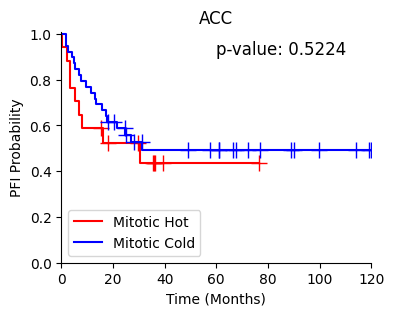

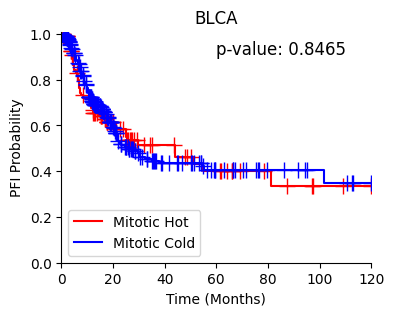

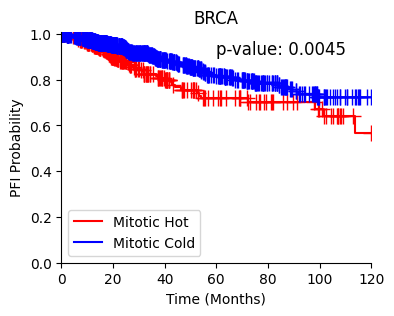

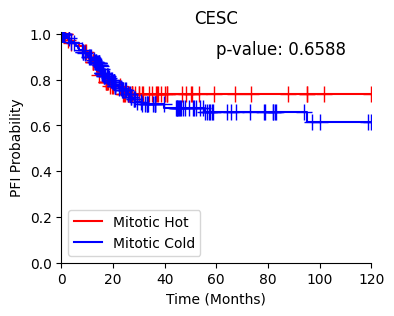

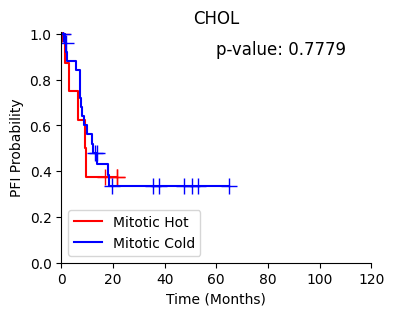

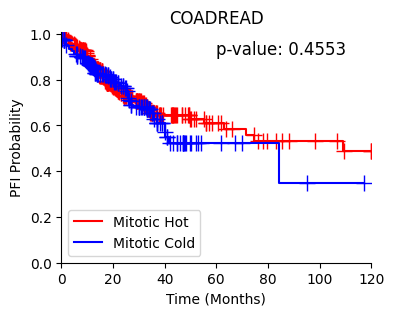

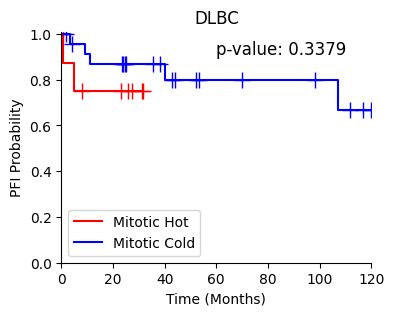

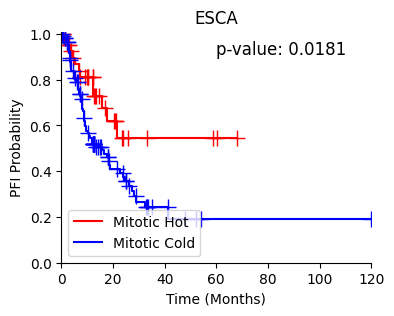

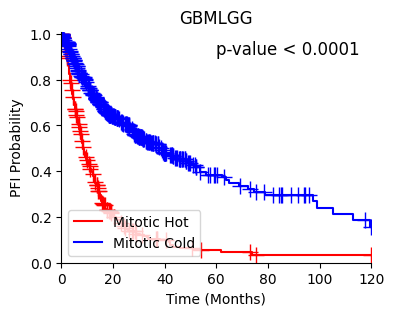

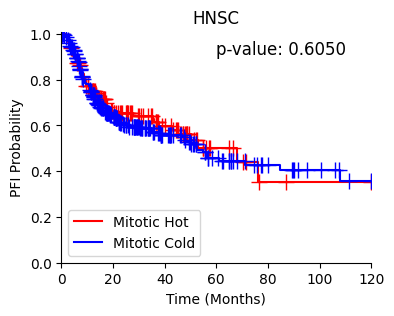

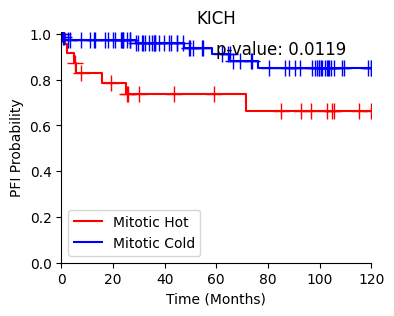

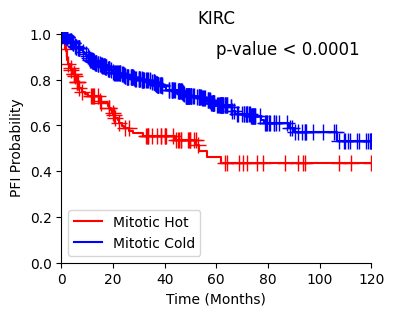

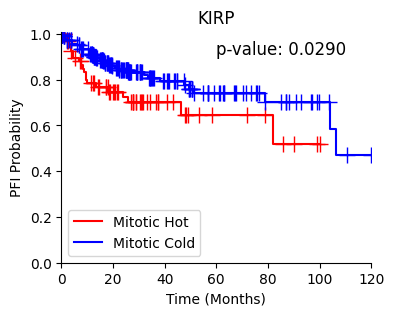

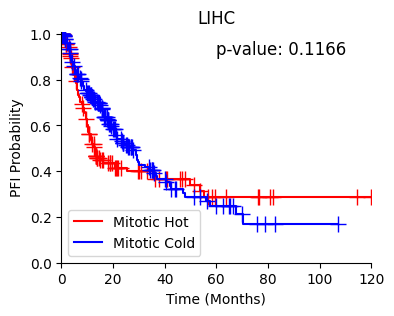

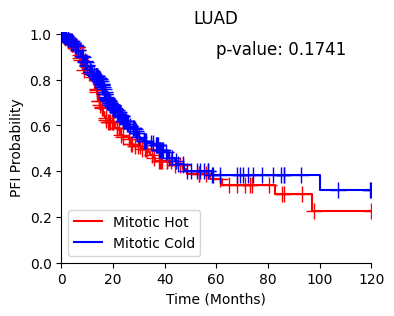

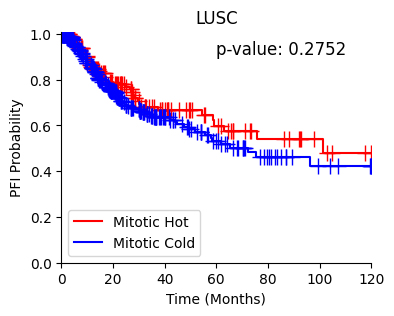

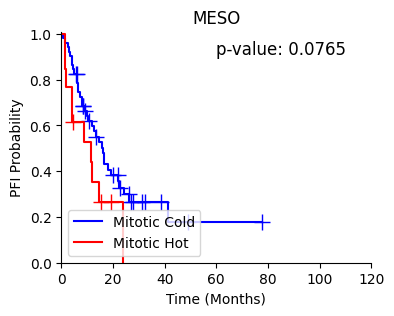

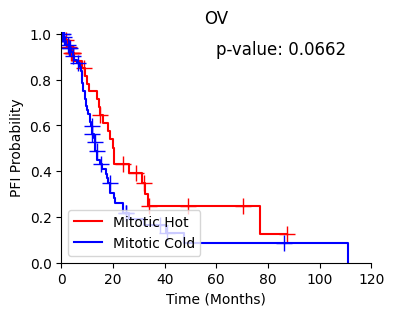

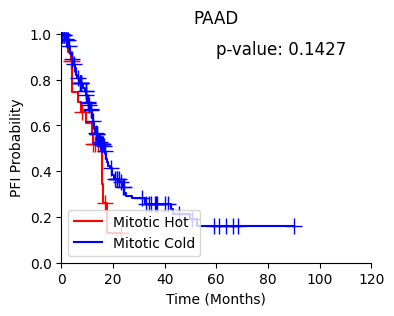

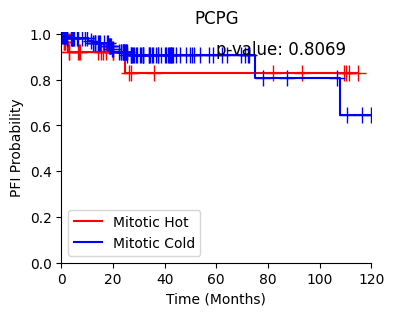

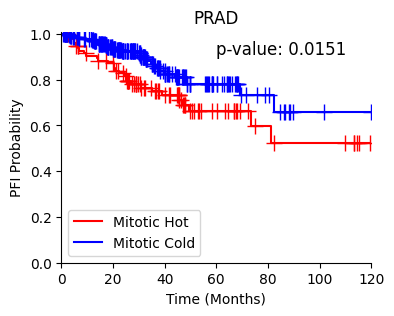

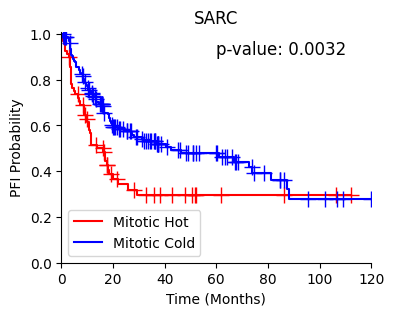

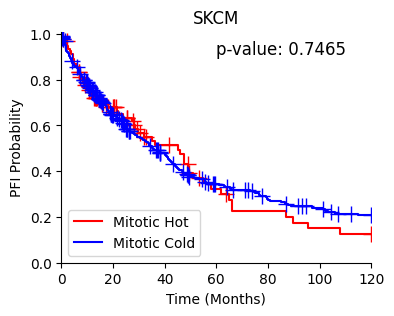

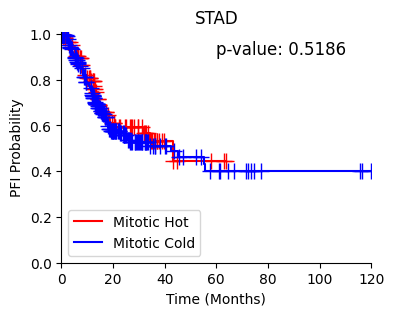

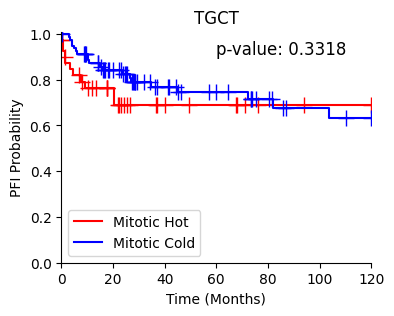

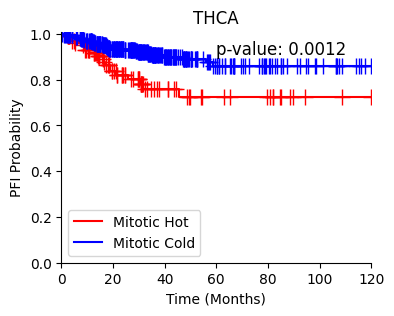

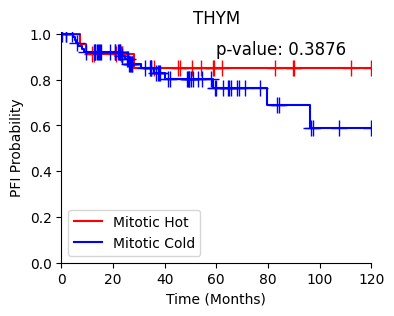

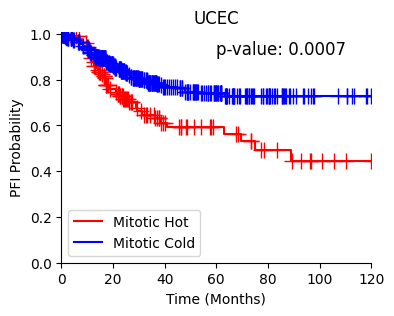

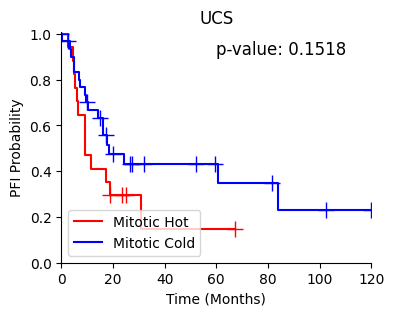

In [3]:
# KM curves on existing temperature
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

ALL_CANCERS = ['SARC',
    'LIHC',
    'THYM',
    'ACC',
    'BRCA',
    'KICH',
    'STAD',
    'BLCA',
    'THCA',
    'GBMLGG',
    'UCEC',
    'LUAD',
    'KIRC',
    'KIRP',
    'PAAD',
    'CESC',
    'PCPG',
    'MESO',
    'SKCM',
    'PRAD',
    'COADREAD',
    'ESCA',
    'LUSC',
    'HNSC',
    'OV',
    'TGCT',
    'CHOL',
    'DLBC',
    'UCS'
 ]

discov_df = pd.read_csv("/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_features_final_ClusterByCancerNew_withAtypicalNew.csv")

for cancer_type in sorted(ALL_CANCERS):
    cancer_type = [cancer_type]
    time_thresh = 120

    print(cancer_type)
    for even_type in ["PFI"]: # "OS", , "DFI"
        time = f"{even_type}.time"
        event = even_type
        cluster = "temperature"
        df = discov_df[discov_df["type"].isin(cancer_type)]
        df = df[[time, event, cluster]]
        df = df.rename(columns={time: 'time', event: 'event', cluster: 'category'})

        df = df.replace(np.inf, np.nan)
        df = df.dropna()

        # Convert days to months
        df["time"] = df["time"] / 30.4

        # Censor at 10 years (120 months)
        if time_thresh is not None:
            df.loc[df["time"] > time_thresh, "event"] = 0
            df.loc[df["time"] > time_thresh, "time"] = time_thresh

        # Initialize the KaplanMeierFitter
        kmf = KaplanMeierFitter()

        # Plotting KM curves for different categories
        plt.figure(figsize=(4, 3))

        # Define the colors and labels for the categories
        category_colors = {"Cold": 'blue', "Hot": 'red'}
        category_labels = {"Cold": f'Mitotic Cold', "Hot": f'Mitotic Hot'}

        # Get the unique categories
        categories = df['category'].unique()

        for category in categories:
            # Filter the data for the current category
            category_data = df[df['category'] == category]
            print(category, len(category_data))
            kmf.fit(durations=category_data['time'], event_observed=category_data['event'], label=category_labels[category])
            kmf.plot(ci_show=False, color=category_colors[category], show_censors=True)
            # # Get confidence intervals
            # ci = kmf.confidence_interval_
            # # Plot fill_between for confidence interval
            # plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color=category_colors[category], alpha=0.3, edgecolor=None)

        plt.ylim([0, 1.01])
        plt.xlim([0, time_thresh])
        # plt.title('Kaplan-Meier Survival Curves for all Cohorts')
        plt.xlabel('Time (Months)')
        plt.ylabel(f'{event} Probability')
        plt.legend(loc = 'lower left')

        # Remove the top and right margins
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Perform Log-Rank test to compare KM curves between all pairs of categories
        results = []
        for (cat1, cat2) in combinations(categories, 2):
            data1 = df[df['category'] == cat1]
            data2 = df[df['category'] == cat2]
            result = logrank_test(data1['time'], data2['time'], event_observed_A=data1['event'], event_observed_B=data2['event'])
            results.append((cat1, cat2, result.p_value))

        # Display p-values for Log-Rank tests
        for cat1, cat2, p_value in results:
            print(f'Log-Rank test p-value between {cat1} and {cat2}: {p_value:.4f}')

        # Add p-value to the plot
        p_value = results[0][2]  # Since there are only two categories, take the first result's p-value
        pv_test = f'p-value: {p_value:.4f}' if p_value>0.0001 else 'p-value < 0.0001'
        plt.text(0.5, 0.90, pv_test, transform=ax.transAxes, fontsize=12)

        plt.title(cancer_type[0])

/tmp/ipykernel_1786306/1886899467.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feats_list] = df[feats_list].astype(float)
/tmp/ipykernel_1786306/1886899467.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feats_list] = (df[feats_list] - df[feats_list].mean()) / (df[feats_list].std() + 1e-300)
/tmp/ipykernel_1786306/1886899467.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

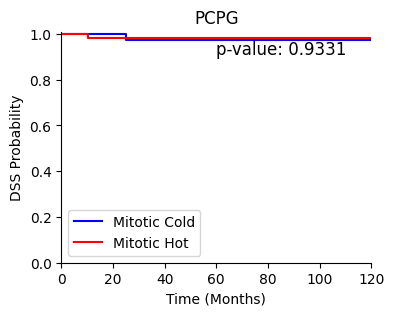

In [47]:
# re-calcuklated the temprature and plot KM

# KM curves on existing temperature
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.cluster import KMeans
from lifelines import CoxPHFitter

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

ALL_CANCERS = ["PCPG"] # ['BRCA', 'KIRC', 'UCEC', 'LGG', 'LUSC', 'LUAD', 'HNSC', 'COADREAD', 'SKCM',
    #    'GBM', 'BLCA', 'STAD', 'LIHC', 'KIRP', 'CESC', 'PAAD', 'ESCA',
    #    'KICH', 'OV']

feats_list = [
    # "mit_hotspot_score",
    "mit_clusterCoff_mean",
    "mit_nodeDegrees_mean",
]

discov_df = pd.read_csv("/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_features_final_ClusterByCancer.csv")


for cancer_type in sorted(ALL_CANCERS):
    cancer_type = [cancer_type]
    time_thresh = 120

    # first find the mitotic-temprature
    df = discov_df[discov_df["type"].isin(cancer_type)]#
    df[feats_list] = df[feats_list].astype(float)

    # Normalize data
    # df[feats_list] = (df[feats_list] - df[feats_list].min()) / (df[feats_list].max() - df[feats_list].min() + 1e-300)
    df[feats_list] = (df[feats_list] - df[feats_list].mean()) / (df[feats_list].std() + 1e-300)

    df[feats_list+["PFI", "PFI.time"]] = df[feats_list+["PFI", "PFI.time"]].replace(np.inf, np.nan)
    df = df[feats_list+["PFI", "PFI.time"]].dropna()
    cph_mva = CoxPHFitter().fit(df, duration_col="PFI.time", event_col="PFI")
    partial_hazard_train = cph_mva.predict_partial_hazard(df[feats_list]).to_numpy().reshape(-1, 1)
    med_haz = np.median(partial_hazard_train)
    partial_hazard_train_ = partial_hazard_train>med_haz
    row_clusters_by_max_clusters = np.int32(partial_hazard_train_)+1


    # Compute the linkage matrix for rows
    # row_linkage = linkage(pdist(df[feats_list]), method='ward')
    # row_clusters_by_max_clusters = fcluster(row_linkage, 2, criterion='maxclust')

    # # do kmeans clustersing
    # row_clusters_by_max_clusters = KMeans(n_clusters=2, random_state=0, n_init=100).fit_predict(partial_hazard_train)

    # Add the cluster labels to the original dataframe
    filtered_indices = df.index
    discov_df.loc[filtered_indices, 'cluster'] = row_clusters_by_max_clusters.tolist()

    # Ensure clusters are integers
    discov_df.loc[filtered_indices, 'cluster'] = discov_df.loc[filtered_indices, 'cluster'].astype(int)

    # Determine which cluster is hot and which is cold based on 'mit_clusterCoff_mean'
    cluster_means = discov_df.loc[filtered_indices].groupby('cluster')['mit_clusterCoff_mean'].mean()

    # Assign hot and cold labels
    hot_cluster = cluster_means.idxmax()
    cold_cluster = cluster_means.idxmin()

    # print(f"{cancer_type} -- Hot: {hot_cluster}, Cold: {cold_cluster}")

    discov_df.loc[filtered_indices, 'temperature'] = discov_df.loc[filtered_indices, 'cluster'].apply(lambda x: 'Hot' if x == hot_cluster else 'Cold')



    for even_type in ["DSS"]: # "OS", , "DFI"
        time = f"{even_type}.time"
        event = even_type
        cluster = "temperature"
        df = discov_df[discov_df["type"].isin(cancer_type)]
        df = df[[time, event, cluster]]
        df = df.rename(columns={time: 'time', event: 'event', cluster: 'category'})

        df = df.replace(np.inf, np.nan)
        df = df.dropna()

        # Convert days to months
        df["time"] = df["time"] / 30

        # Censor at 10 years (120 months)
        if time_thresh is not None:
            df.loc[df["time"] > time_thresh, "event"] = 0
            df.loc[df["time"] > time_thresh, "time"] = time_thresh

        # Initialize the KaplanMeierFitter
        kmf = KaplanMeierFitter()

        # Plotting KM curves for different categories
        plt.figure(figsize=(4, 3))

        # Define the colors and labels for the categories
        category_colors = {"Cold": 'blue', "Hot": 'red'}
        category_labels = {"Cold": f'Mitotic Cold', "Hot": f'Mitotic Hot'}

        # Get the unique categories
        categories = df['category'].unique()

        for category in categories:
            # Filter the data for the current category
            category_data = df[df['category'] == category]
            kmf.fit(durations=category_data['time'], event_observed=category_data['event'], label=category_labels[category])
            kmf.plot(ci_show=False, color=category_colors[category])
            # # Get confidence intervals
            # ci = kmf.confidence_interval_
            # # Plot fill_between for confidence interval
            # plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color=category_colors[category], alpha=0.3, edgecolor=None)

        plt.ylim([0, 1.01])
        plt.xlim([0, time_thresh])
        # plt.title('Kaplan-Meier Survival Curves for all Cohorts')
        plt.xlabel('Time (Months)')
        plt.ylabel(f'{event} Probability')
        plt.legend(loc = 'lower left')

        # Remove the top and right margins
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Perform Log-Rank test to compare KM curves between all pairs of categories
        results = []
        for (cat1, cat2) in combinations(categories, 2):
            data1 = df[df['category'] == cat1]
            data2 = df[df['category'] == cat2]
            result = logrank_test(data1['time'], data2['time'], event_observed_A=data1['event'], event_observed_B=data2['event'])
            results.append((cat1, cat2, result.p_value))

        # # Display p-values for Log-Rank tests
        # for cat1, cat2, p_value in results:
        #     print(f'Log-Rank test p-value between {cat1} and {cat2}: {p_value:.4f}')

        # Add p-value to the plot
        p_value = results[0][2]  # Since there are only two categories, take the first result's p-value
        pv_test = f'p-value: {p_value:.4f}' if p_value>0.0001 else 'p-value < 0.0001'
        plt.text(0.5, 0.90, pv_test, transform=ax.transAxes, fontsize=12)

        plt.title(cancer_type[0])